In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from path_explain import set_up_environment
from gradients import GradientExplainerTF

In [3]:
set_up_environment(visible_devices='0')

In [4]:
x = np.random.randn(100, 2).astype(np.float32)
y = x[:, 0] + np.random.randn(100) * 0.1

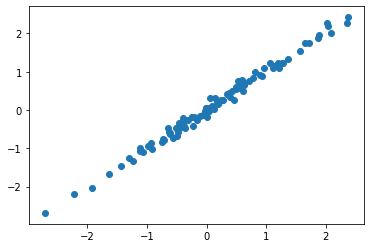

In [5]:
plt.scatter(x[:, 0], y)

In [6]:
model = tf.keras.models.Sequential()
model.add(tf.keras.layers.Input(shape=(2,)))
model.add(tf.keras.layers.Dense(8))
model.add(tf.keras.layers.Activation(tf.keras.activations.relu))
model.add(tf.keras.layers.Dense(1))

In [7]:
model.layers[0].weights[0]

<tf.Variable 'dense/kernel:0' shape=(2, 8) dtype=float32, numpy=
array([[-0.06247556,  0.15779036,  0.6914294 ,  0.26529598, -0.6993861 ,
         0.25997686, -0.6677437 ,  0.04861528],
       [ 0.0569433 ,  0.67670095,  0.27014756, -0.72139126,  0.00326014,
        -0.5402215 , -0.13996637, -0.25491858]], dtype=float32)>

In [8]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 8)                 24        
_________________________________________________________________
activation (Activation)      (None, 8)                 0         
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 9         
Total params: 33
Trainable params: 33
Non-trainable params: 0
_________________________________________________________________


In [9]:
model.compile(optimizer=tf.keras.optimizers.SGD(learning_rate=0.1),
              loss=tf.keras.losses.MeanSquaredError())
model.fit(x, y, batch_size=50, epochs=10)

Train on 100 samples
Epoch 1/10
100/100 [==============================] - 0s 3ms/sample - loss: 0.3182
Epoch 2/10
100/100 [==============================] - 0s 56us/sample - loss: 0.1725
Epoch 3/10
100/100 [==============================] - 0s 56us/sample - loss: 0.1052
Epoch 4/10
100/100 [==============================] - 0s 53us/sample - loss: 0.0674
Epoch 5/10
100/100 [==============================] - 0s 35us/sample - loss: 0.0517
Epoch 6/10
100/100 [==============================] - 0s 35us/sample - loss: 0.0426
Epoch 7/10
100/100 [==============================] - 0s 38us/sample - loss: 0.0377
Epoch 8/10
100/100 [==============================] - 0s 38us/sample - loss: 0.0348
Epoch 9/10
100/100 [==============================] - 0s 38us/sample - loss: 0.0325
Epoch 10/10
100/100 [==============================] - 0s 38us/sample - loss: 0.0307


In [13]:
y_pred = model.predict(x)

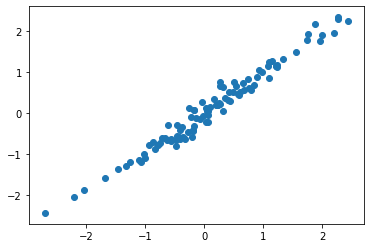

In [11]:
plt.scatter(y, y_pred)

In [20]:
explainer = GradientExplainerTF(model)

In [25]:
attributions = explainer.attributions(x,
                                      multiply_by_input=True)

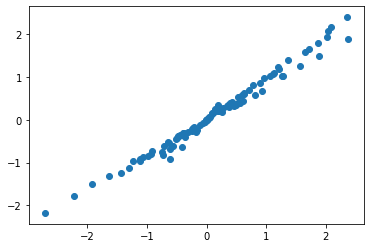

In [22]:
plt.scatter(x[:, 0], attributions[:, 0])

In [26]:
interactions = explainer.interactions(x,
                                      multiply_by_input=True)